# ARFS applied to regression

ARFS can be used for classification (binary or multi-class) and for regression. You just have to specify the right loss function.



In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
import catboost
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
import arfs
import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.utils import highlight_tick, compare_varimp
from arfs.utils import load_data, sklearn_pimp_bench
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 0.3.8


In [3]:
%matplotlib inline

In [4]:
gc.enable()
gc.collect()

4

## Simple Usage
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.

## Leshy (Boruta evolution)

In [5]:
boston = load_data(name='Boston')
X, y = boston.data, boston.target

In [6]:
X.dtypes

CRIM             float64
ZN               float64
INDUS            float64
CHAS            category
NOX              float64
RM               float64
AGE              float64
DIS              float64
RAD             category
TAX              float64
PTRATIO          float64
B                float64
LSTAT            float64
random_num1      float64
random_num2        int32
random_cat      category
random_cat_2    category
genuine_num      float64
dtype: object

In [7]:
X.head()

CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0     15.3   
1  0.02731   0.0   7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0     17.8   
2  0.02729   0.0   7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0     17.8   
3  0.03237   0.0   2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0     18.7   
4  0.06905   0.0   2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0     18.7   

        B  LSTAT  random_num1  random_num2 random_cat random_cat_2  \
0  396.90   4.98     0.496714            2   cat_3517          SAS   
1  396.90   9.14    -0.138264            1   cat_2397   Terminator   
2  392.83   4.03     0.647689            3   cat_3735       Lecter   
3  394.63   2.94     1.523030            0   cat_2870  Creationist   
4  396.90   5.33    -0.234153            1   cat_1160         Rick   

   genuine_num  
0     6.255169  
1     4.842180  
2     6.669977  
3     6.280167  
4     8.365475

In [8]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMRegressor(random_state=42, verbose=-1)

In [9]:
%%time

# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:01<00:00,  4.88it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	3
Rejected: 	8
All relevant predictors selected in 00:00:01.87
['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT', 'genuine_num']


CPU times: total: 10.8 s
Wall time: 2.61 s


In [10]:
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")

The agnostic ranking: [ 1 10  2  5  1  1  2  1  8  5  1  2  1  3  9  5  7  1]
The naive ranking: ['RM', 'genuine_num', 'NOX', 'LSTAT', 'PTRATIO', 'DIS', 'CRIM', 'AGE', 'INDUS', 'B', 'random_num1', 'random_cat', 'CHAS', 'TAX', 'random_cat_2', 'RAD', 'random_num2', 'ZN']


In [11]:
feat_selector.tag_df

predictor  Boruta  Boruta_weak_incl
0           CRIM       1                 1
1             ZN       0                 0
2          INDUS       0                 1
3           CHAS       0                 0
4            NOX       1                 1
5             RM       1                 1
6            AGE       0                 1
7            DIS       1                 1
8            RAD       0                 0
9            TAX       0                 0
10       PTRATIO       1                 1
11             B       0                 1
12         LSTAT       1                 1
13   random_num1       0                 0
14   random_num2       0                 0
15    random_cat       0                 0
16  random_cat_2       0                 0
17   genuine_num       1                 1

## BoostAGroota

In [12]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')

plt.show()

BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:03<00:28,  3.15s/it]


0           CRIM
1            NOX
2             RM
3            DIS
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


CPU times: total: 13 s
Wall time: 3.56 s


In [13]:
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")

The agnostic ranking: [1 2 2 2 1 1 2 1 2 2 1 2 1 2 2 2 2 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'DIS', 'NOX', 'CRIM', 'B', 'AGE', 'TAX', 'random_cat', 'random_num1', 'INDUS', 'random_cat_2', 'CHAS', 'RAD', 'random_num2', 'ZN']


## GrootCV

Repeated k-fold: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.96it/s]


0             AGE
2            CRIM
3             DIS
5           LSTAT
6             NOX
7         PTRATIO
8              RM
9             TAX
11    genuine_num
Name: feature, dtype: object


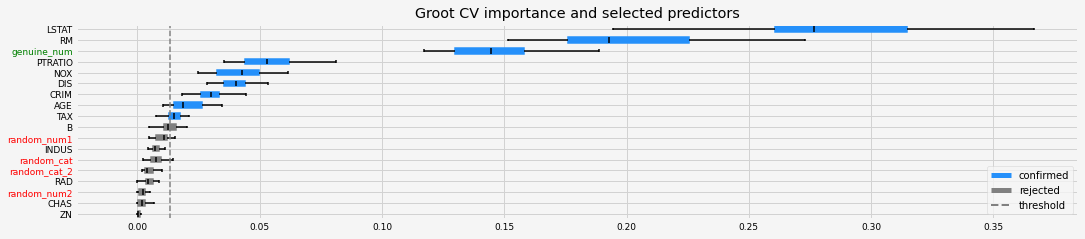

CPU times: total: 34.8 s
Wall time: 6.79 s


In [14]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='rmse', cutoff = 1, n_folds=5, n_iter=5)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')

plt.show()

In [15]:
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")

The agnostic ranking: [1 2 2 2 1 1 1 1 2 1 1 2 1 2 2 2 2 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'NOX', 'DIS', 'CRIM', 'AGE', 'TAX', 'B', 'random_num1', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'random_num2', 'CHAS', 'ZN']


## Testing and comparing Leshy, GrootCV and BoostAGroota 

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.

==================== Benchmarking using sklearn permutation importance ====================


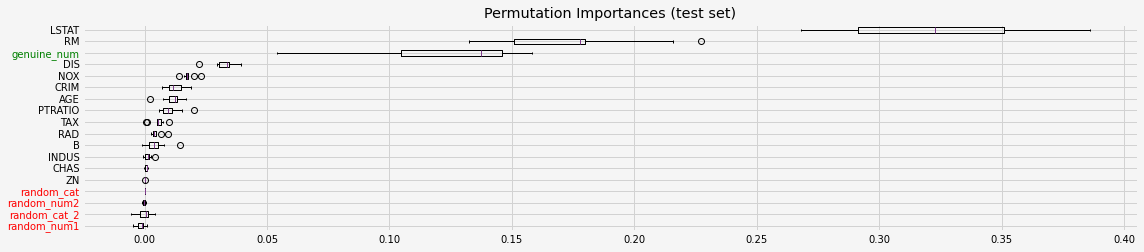

CPU times: total: 3.39 s
Wall time: 3.93 s


In [16]:
%%time
model = clone(model)
# Benchmark with scikit-learn permutation importance
print('=' * 20 + ' Benchmarking using sklearn permutation importance ' + '=' * 20)
fig = sklearn_pimp_bench(model, X, y, task='regression', sample_weight=None)

### Testing Leshy

Leshy seems to struggle with catboost, for regression and this particular data set whereas the other ARFS methods seem OK. To be investigated.

==================== Leshy - testing:     RandomForestRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:13<00:01,  1.53s/it]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:13.75
['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


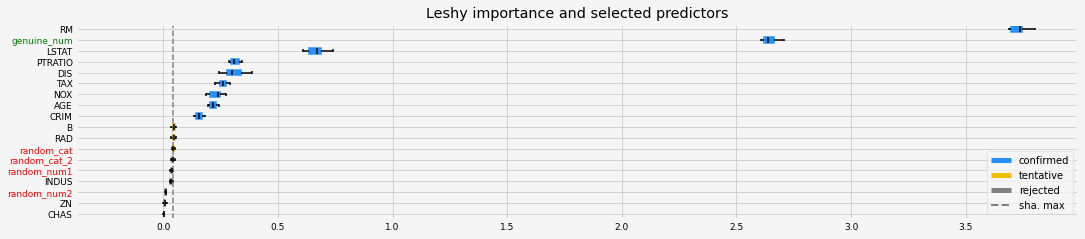

==================== Leshy - testing:     RandomForestRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:23<00:02,  2.59s/it]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	0
Rejected: 	9
All relevant predictors selected in 00:00:23.36
['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


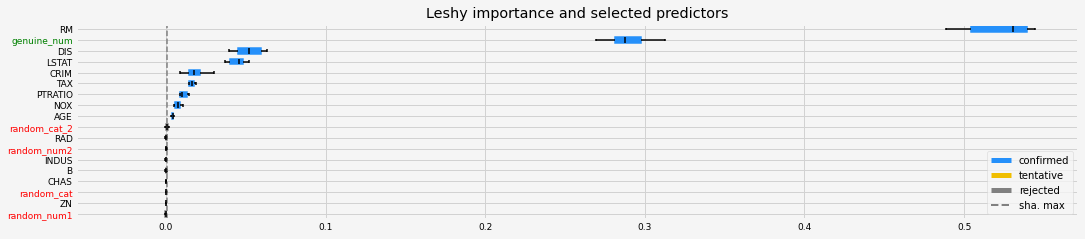

==================== Leshy - testing:     RandomForestRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:04<00:00,  2.03it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	1
Rejected: 	7
All relevant predictors selected in 00:00:04.44
['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


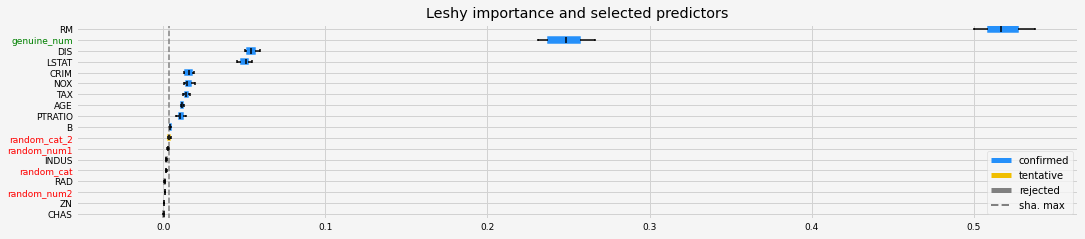

==================== Leshy - testing:         CatBoostRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:54<00:06,  6.01s/it]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	3
Rejected: 	11
All relevant predictors selected in 00:00:54.13
['ZN', 'INDUS', 'NOX', 'RAD']


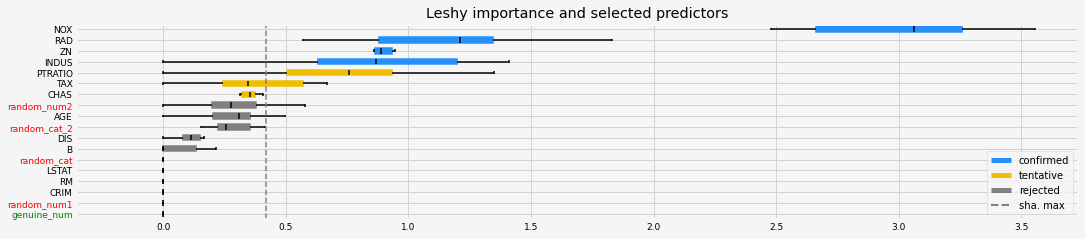

==================== Leshy - testing:         CatBoostRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:53<00:05,  5.96s/it]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	4
Rejected: 	12
All relevant predictors selected in 00:00:53.65
['ZN', 'NOX']


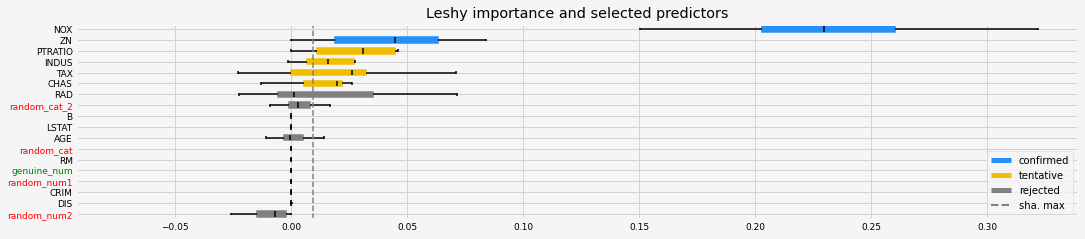

==================== Leshy - testing:         CatBoostRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:50<00:05,  5.61s/it]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	13
All relevant predictors selected in 00:00:50.47
['ZN', 'NOX']


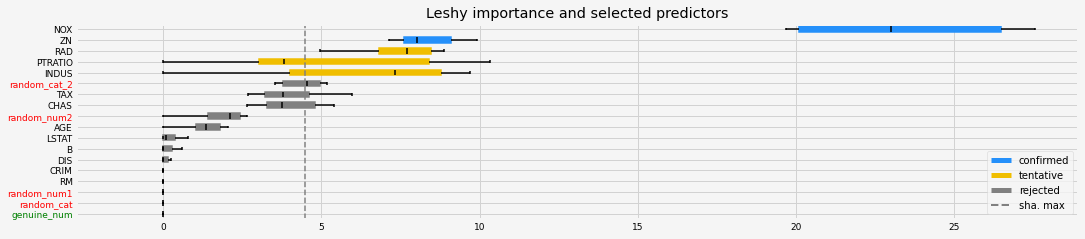

==================== Leshy - testing:              XGBRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:04<00:00,  2.22it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:04.07
['CRIM', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'random_cat', 'genuine_num']


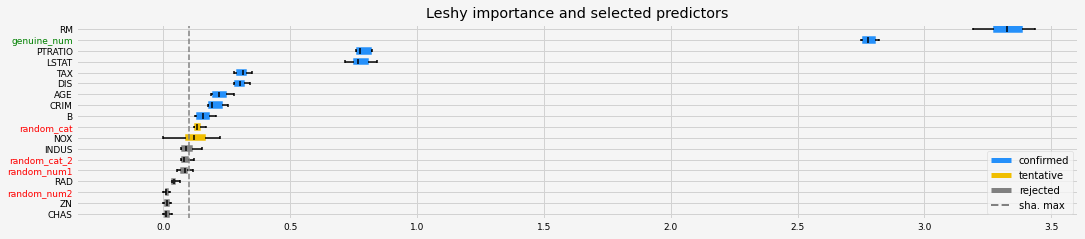

==================== Leshy - testing:              XGBRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:12<00:01,  1.35s/it]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	1
Rejected: 	10
All relevant predictors selected in 00:00:12.21
['CRIM', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


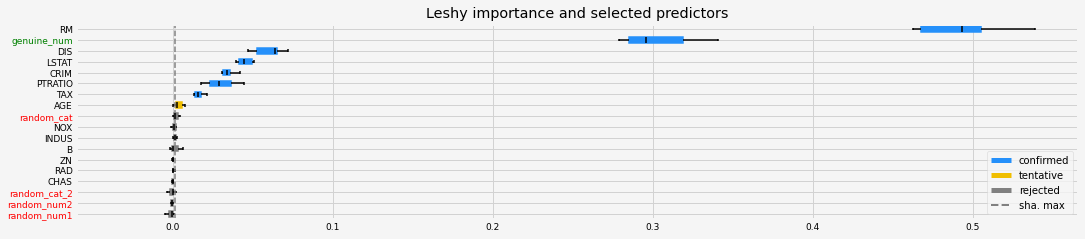

==================== Leshy - testing:              XGBRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:02<00:00,  3.29it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	8
Tentative: 	3
Rejected: 	7
All relevant predictors selected in 00:00:02.75
['CRIM', 'NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


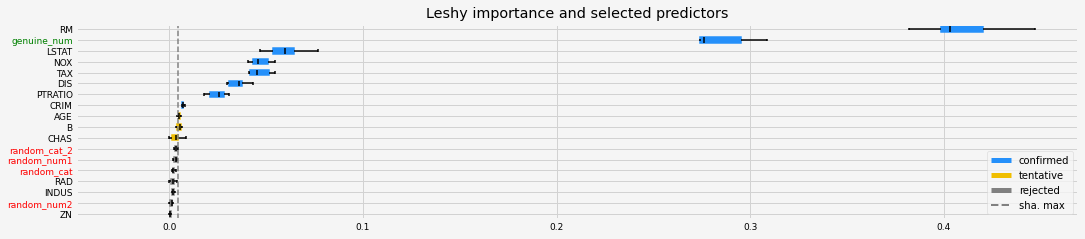

==================== Leshy - testing:             LGBMRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:01<00:00,  5.76it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	8
Tentative: 	0
Rejected: 	10
All relevant predictors selected in 00:00:01.58
['NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


==================== Leshy - testing:             LGBMRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:04<00:00,  1.92it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	5
Rejected: 	6
All relevant predictors selected in 00:00:04.72
['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


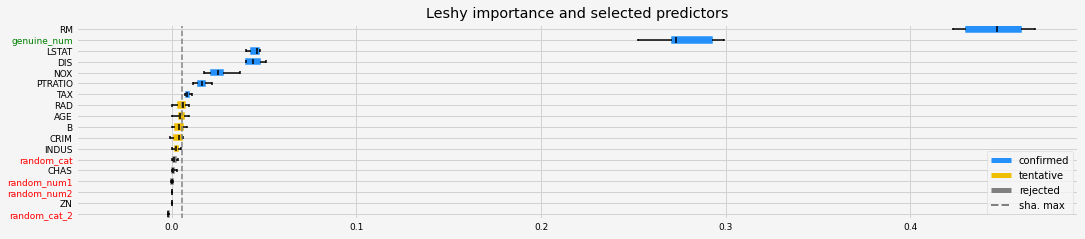

==================== Leshy - testing:             LGBMRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:01<00:00,  5.87it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	11
All relevant predictors selected in 00:00:01.55
['RM', 'AGE', 'DIS', 'LSTAT', 'genuine_num']


==================== Leshy - testing:             LGBMRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:01<00:00,  6.02it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	13
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:01.51
['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


==================== Leshy - testing:             LGBMRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:03<00:00,  2.46it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:03.68
['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


==================== Leshy - testing:             LGBMRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9/10 [00:01<00:00,  7.28it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:01.26
['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


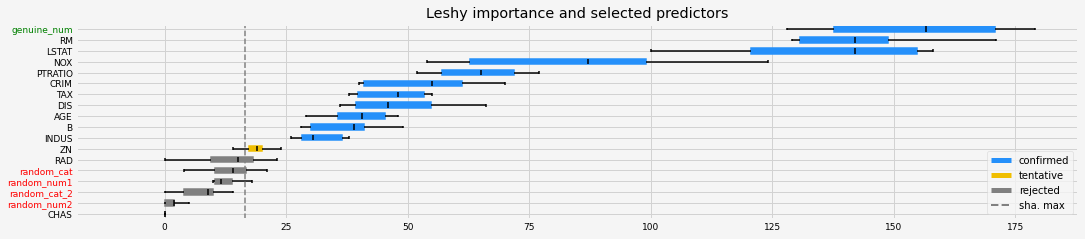

In [17]:
models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
          CatBoostRegressor(random_state=42, verbose=0), 
          XGBRegressor(random_state=42, verbosity=0), 
          LGBMRegressor(random_state=42, verbose=-1),
          LightForestRegressor(n_feat=X.shape[1])]

feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42)

if __name__ == '__main__':
    # regression
    boston = load_data(name='Boston')
    X, y = boston.data, boston.target
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

### Testing GrootCV

Repeated k-fold: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.99it/s]


0             AGE
2            CRIM
3             DIS
5           LSTAT
6             NOX
7         PTRATIO
8              RM
9             TAX
11    genuine_num
Name: feature, dtype: object


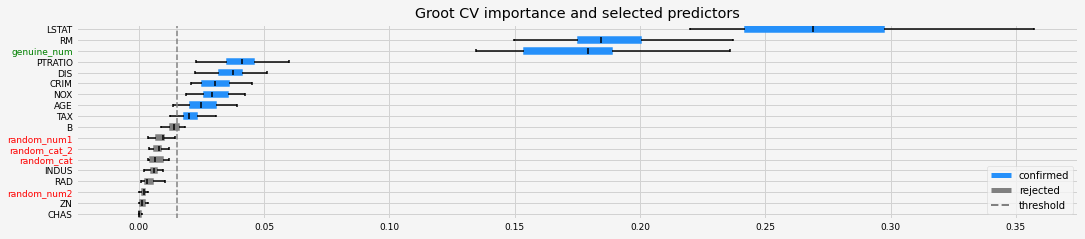

In [18]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective='rmse'):
    feat_selector = arfsgroot.GrootCV(objective=objective, cutoff = 1, n_folds=5, n_iter=5)
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.support_names_)
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match='random')
    fig = highlight_tick(figure=fig, str_match='genuine', color='green')
    plt.show()
    gc.enable()
    del(feat_selector)
    gc.collect()
        

if __name__ == '__main__':
    # regression
    boston = load_data(name='Boston')
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    testing_estimators(X=X, y=y, objective='rmse')

### Testing BoostAGroota

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:02<00:18,  2.05s/it]


0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:07<01:05,  7.31s/it]


0           CRIM
1            NOX
2             RM
3            DIS
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


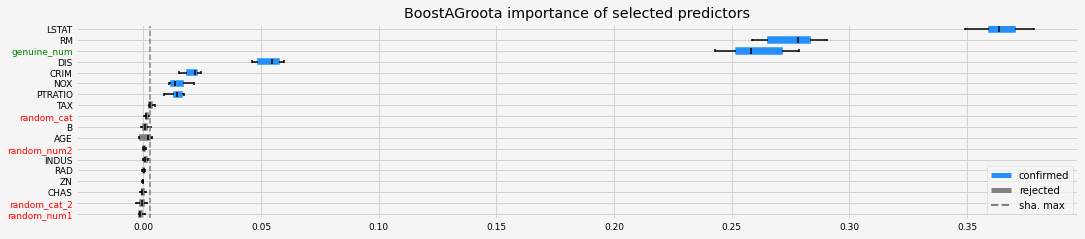

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:01<00:14,  1.57s/it]


0             RM
1            AGE
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


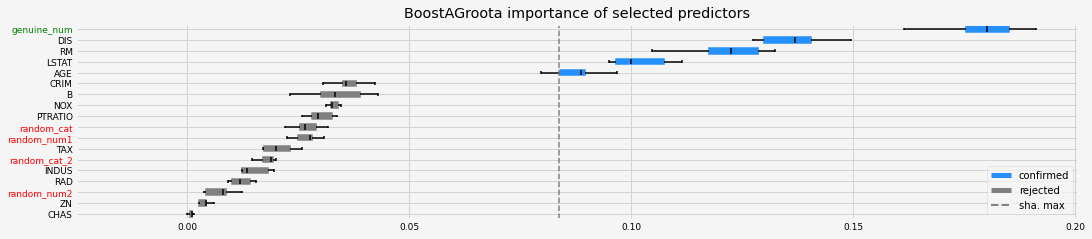

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:01<00:14,  1.64s/it]


0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5        PTRATIO
6              B
7          LSTAT
8    genuine_num
Name: feature, dtype: object


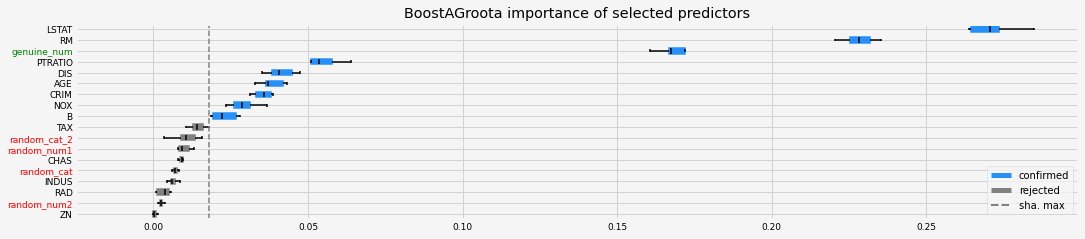

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:07<01:08,  7.60s/it]


0           CRIM
1            NOX
2             RM
3            DIS
4            TAX
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:01<00:15,  1.69s/it]


0           CRIM
1             RM
2            AGE
3            DIS
4              B
5          LSTAT
6    genuine_num
Name: feature, dtype: object


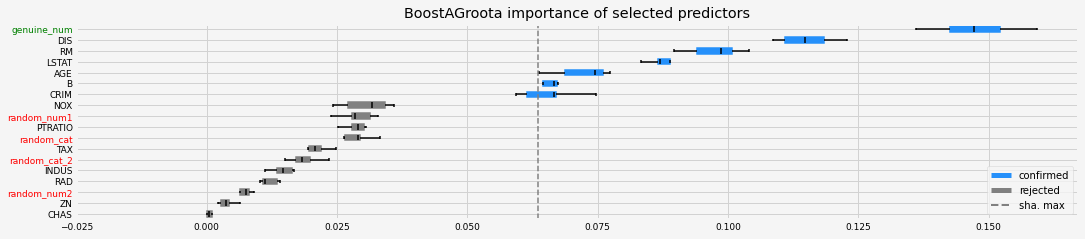

==================== BoostAGroota - testing:              XGBRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:01<00:15,  1.76s/it]


0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


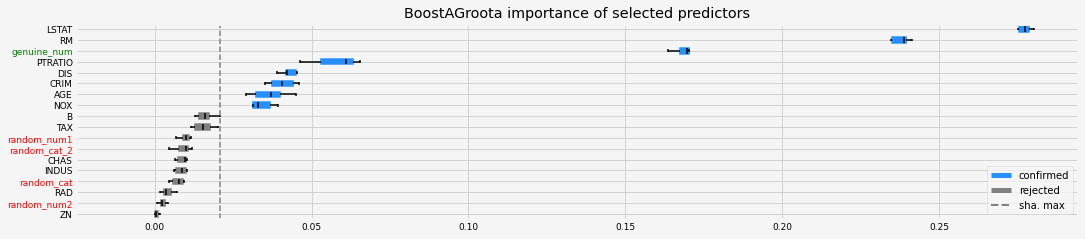

==================== BoostAGroota - testing:              XGBRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:07<01:04,  7.15s/it]


0           CRIM
1            NOX
2             RM
3            DIS
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


==================== BoostAGroota - testing:              XGBRegressor for var.imp: native          ====================


BoostaGRoota round:  20%|███████████████████████████▏                                                                                                            | 2/10 [00:02<00:11,  1.39s/it]


0           CRIM
1             RM
2            AGE
3            DIS
4          LSTAT
5    genuine_num
Name: feature, dtype: object


==================== BoostAGroota - testing:             LGBMRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:01<00:14,  1.59s/it]


0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


==================== BoostAGroota - testing:             LGBMRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:07<01:06,  7.34s/it]


0           CRIM
1            NOX
2             RM
3            DIS
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


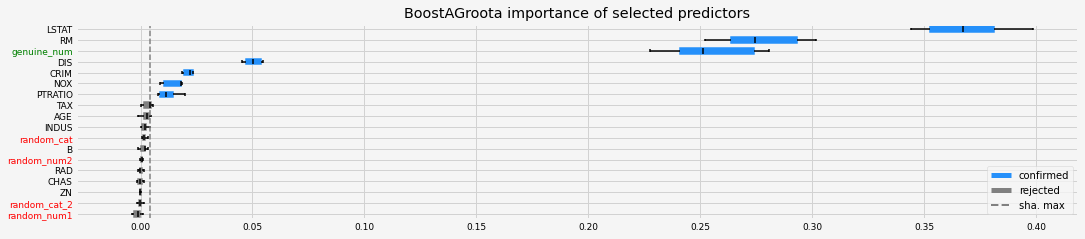

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: native          ====================


BoostaGRoota round:  20%|███████████████████████████▏                                                                                                            | 2/10 [00:02<00:10,  1.28s/it]


0             RM
1            DIS
2          LSTAT
3    genuine_num
Name: feature, dtype: object


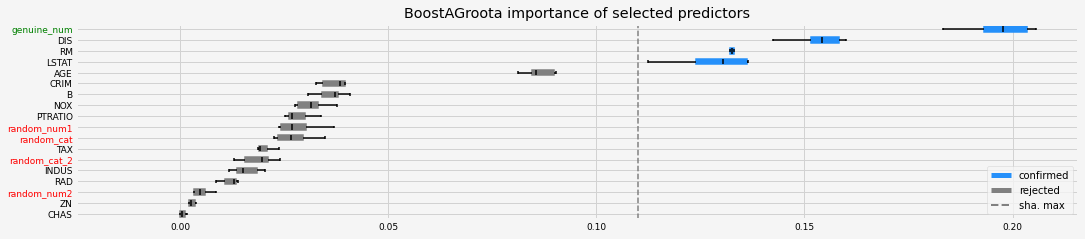

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:02<00:19,  2.17s/it]


0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


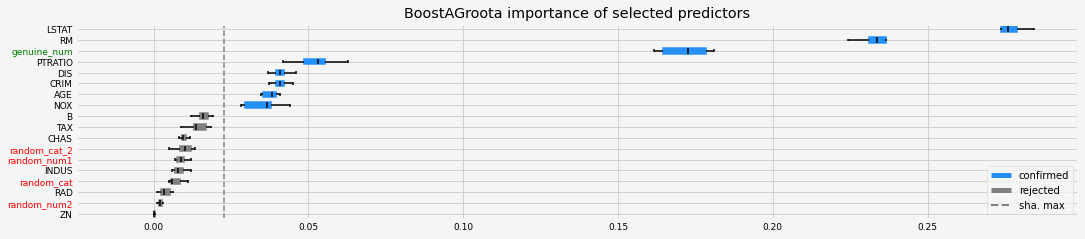

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▌                                                                                                                          | 1/10 [00:08<01:14,  8.27s/it]


0           CRIM
1            NOX
2             RM
3            DIS
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


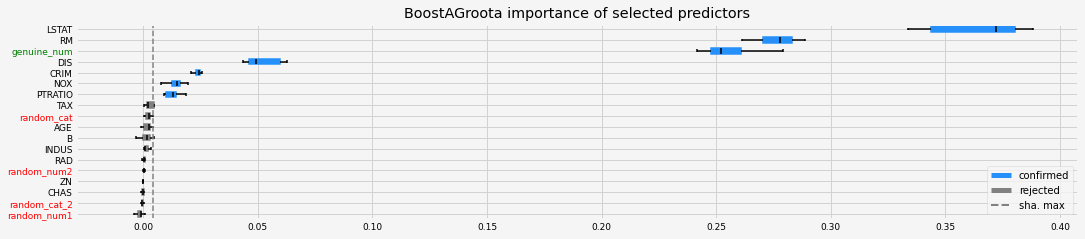

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: native          ====================


BoostaGRoota round:  20%|███████████████████████████▏                                                                                                            | 2/10 [00:02<00:11,  1.44s/it]


0           CRIM
1             RM
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


In [19]:
models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
          CatBoostRegressor(random_state=42, verbose=0), 
          XGBRegressor(random_state=42, verbosity=0), 
          LGBMRegressor(random_state=42, verbose=-1),
          LightForestRegressor(n_feat=X.shape[1])]

feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1)

if __name__ == '__main__':
    # regression
    boston = load_data(name='Boston')
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)